<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [118]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [119]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-06-25 08:18:20--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-06-25 08:18:20 (12.4 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [120]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [121]:
df.shape

(346, 10)

### Convert to date time object 

In [122]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [123]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [124]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

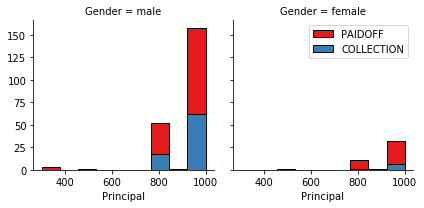

In [125]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

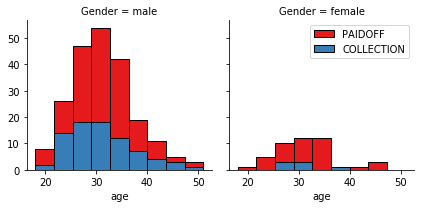

In [126]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

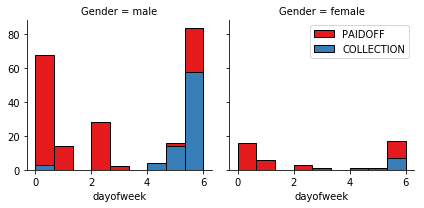

In [127]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [128]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [129]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [130]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [131]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [132]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [133]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [134]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [135]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## The train/test split - (using the same split for all models)

In [136]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=4)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (294, 8) (294,)
Test set: (52, 8) (52,)


## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [137]:
# I'm doing the Standerdization after the train test split as mentioned in the sample notebook.

sc = preprocessing.StandardScaler()
X_train= sc.fit(X_train).transform(X_train.astype(float))
X_train[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


array([[-1.2347344 , -0.96777078, -0.82481018, -0.40256097, -1.16275535,
        -0.39107694,  1.10782342, -0.83631451],
       [ 0.54910793,  0.93923062,  0.32367382, -0.40256097,  0.86002615,
        -0.39107694, -0.90267093,  1.1957224 ],
       [-3.91049789, -1.98483819, -1.48108675, -0.40256097, -1.16275535,
        -0.39107694,  1.10782342, -0.83631451],
       [-1.2347344 , -0.96777078,  3.27691837, -0.40256097, -1.16275535,
        -0.39107694, -0.90267093,  1.1957224 ],
       [ 0.54910793,  0.93923062,  1.30808867, -0.40256097, -1.16275535,
        -0.39107694,  1.10782342, -0.83631451]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

### Finding the best 'k' in KNN

Mean accuracy  [0.51923077 0.19230769 0.69230769 0.59615385 0.80769231 0.80769231
 0.80769231 0.80769231 0.80769231 0.80769231 0.80769231 0.80769231
 0.80769231 0.80769231]
Max mean accuracy is:  0.8076923076923077  when k=  5
 Best k value is: 5


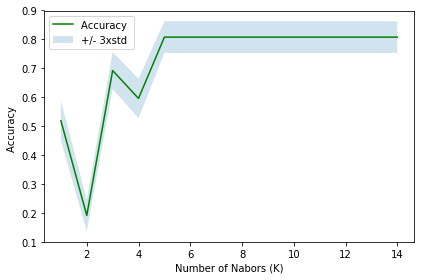

In [138]:
from sklearn.neighbors import KNeighborsClassifier

Ks = 15
mean_accuracy = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
best_k = 1
#ConfustionMx = [];

for n in range(1,Ks):
    #Train Model and Predict  
    kNN = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=kNN.predict(X_test)
    mean_accuracy[n-1] = metrics.accuracy_score(y_test, yhat)
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])


best_k = mean_accuracy.argmax()+1

print ("Mean accuracy ", mean_accuracy)
print("Max mean accuracy is: ",mean_accuracy.max(), " when k= ",best_k)
print(" Best k value is:", best_k);


plt.plot(range(1,Ks),mean_accuracy,'g')
plt.fill_between(range(1,Ks), mean_accuracy - 1 * std_acc, mean_accuracy + 1 * std_acc, alpha=0.2)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [139]:
# in accordance with the above found best k value 
# Train KNN model

kNN_model = KNeighborsClassifier(n_neighbors = best_k).fit(X_train,y_train)
kNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [140]:
print("Please see below section for the proper model evaluation using the given \"test set\" ")

yhat = kNN_model.predict(X_test)
yhat[0:5]


Please see below section for the proper model evaluation using the given "test set" 


array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [141]:
from sklearn import metrics
print("kNN Train split set Accuracy: ", metrics.accuracy_score(y_train, kNN_model.predict(X_train)))
print("kNN Test split set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("Please see below section for the proper model evaluation using the given \"test set\" ")

kNN Train split set Accuracy:  0.8095238095238095
kNN Test split set Accuracy:  0.8076923076923077
Please see below section for the proper model evaluation using the given "test set" 


# Decision Tree

In [142]:
from sklearn.tree import DecisionTreeClassifier

n_max_depth = 15
best_max_depth = 1
lists = [[],[]]

for m in range(2, n_max_depth):
    # modelling
    Tree = DecisionTreeClassifier(criterion="entropy", max_depth = m)
    #Tree
    Tree.fit(X_train, y_train)
    pred = Tree.predict(X_test)

    # evaluation
    from sklearn import metrics
    import matplotlib.pyplot as plt
    acc = metrics.accuracy_score(y_test, pred)
    # print("Accuracy of decision tree: ", acc, ", depth = ", m)
    
    lists[0].append(acc)
    lists[1].append(m)
    if acc== max(lists[0]):
        best_acc = acc
        best_max_depth = m
        best_tree = Tree

print("The best accuracy of DT is ", best_acc, "with a max depth of", best_max_depth, '\n')

The best accuracy of DT is  0.8076923076923077 with a max depth of 4 



In [143]:
# in accordance with the above found best "max-depth" value
# Train the Decision tree

DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = best_max_depth)
#DTree # it shows the default parameters

DT_model.fit(X_train,y_train)
DT_model

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [144]:
print("Please see below section for the proper model evaluation using the given \"test set\" ")

yhat = DT_model.predict(X_test)
yhat


Please see below section for the proper model evaluation using the given "test set" 


array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [145]:
from sklearn import metrics
print("DT Train split set Accuracy: ", metrics.accuracy_score(y_train, DT_model.predict(X_train)))
print("DT Test split set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("Please see below section for the proper model evaluation using the given \"test set\" ")


DT Train split set Accuracy:  0.7448979591836735
DT Test split set Accuracy:  0.8076923076923077
Please see below section for the proper model evaluation using the given "test set" 


# Support Vector Machine

In [146]:
from sklearn import svm

SVM_model = svm.SVC(kernel='rbf')
SVM_model.fit(X_train, y_train) 
SVM_model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [147]:
print("Please see below section for the proper model evaluation using the given \"test set\" ")
yhat = SVM_model.predict(X_test)
yhat

Please see below section for the proper model evaluation using the given "test set" 


array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [148]:
from sklearn import metrics
print("SVM Train split set Accuracy: ", metrics.accuracy_score(y_train, SVM_model.predict(X_train)))
print("SVM Test split set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("Please see below section for the proper model evaluation using the given \"test set\" ")

SVM Train split set Accuracy:  0.7619047619047619
SVM Test split set Accuracy:  0.8076923076923077
Please see below section for the proper model evaluation using the given "test set" 


# Logistic Regression

In [149]:
from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import confusion_matrix

LR_model = LogisticRegression(C=0.1, solver='liblinear').fit(X_train,y_train)

# usinng C=0.1 as it gives a better result than C=0.01


In [150]:
print("Please see below section for the proper model evaluation using the given \"test set\" ")
yhat = LR_model.predict(X_test)
yhat

Please see below section for the proper model evaluation using the given "test set" 


array(['COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION'],
      dtype=object)

In [151]:
print("Please see below section for the proper model evaluation using the given \"test set\" ")
yhatprob = LR_model.predict_proba(X_test)
yhatprob[0:5]

Please see below section for the proper model evaluation using the given "test set" 


array([[1.00000000e+00, 9.66325555e-16],
       [1.00000000e+00, 5.15048695e-12],
       [1.00000000e+00, 1.46642140e-14],
       [1.00000000e+00, 1.51573581e-15],
       [1.00000000e+00, 4.24494571e-15]])

In [152]:
from sklearn import metrics
print("Please see below section for the proper model evaluation using the given \"test set\" ")

print("LR Train split set Accuracy: ", metrics.accuracy_score(y_train, LR_model.predict(X_train)))
print("LR Test split set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print("LR Test split log loss: ", metrics.log_loss(y_test, yhatprob))


Please see below section for the proper model evaluation using the given "test set" 
LR Train split set Accuracy:  0.7448979591836735
LR Test split set Accuracy:  0.19230769230769232
LR Test split log loss:  25.90544332951441


# Model Evaluation using Test set

In [153]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [154]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-06-25 08:18:22--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-06-25 08:18:23 (299 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [155]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Pre-processing

In [156]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

Xtest = Feature
#Xtest = preprocessing.StandardScaler().fit(Xtest).transform(Xtest.astype(float))

#using the StandardScalar() initilized before (for the training set) and not doing a fit() as instructed by a better expert than my self.
Xtest = sc.transform(Feature.astype(float))
Xtest[0:5]

array([[ 0.54910793,  0.93923062,  3.11284923,  2.48409575, -1.16275535,
         2.55704156, -0.90267093, -0.83631451],
       [-5.69434022, -1.98483819,  0.6518121 , -0.40256097,  0.86002615,
        -0.39107694, -0.90267093, -0.83631451],
       [ 0.54910793,  0.93923062,  1.96436524,  2.48409575,  0.86002615,
        -0.39107694,  1.10782342, -0.83631451],
       [ 0.54910793,  0.93923062, -0.82481018, -0.40256097,  0.86002615,
        -0.39107694, -0.90267093,  1.1957224 ],
       [-1.2347344 , -0.96777078, -0.33260275, -0.40256097,  0.86002615,
         2.55704156, -0.90267093, -0.83631451]])

In [157]:
Ytest = test_df['loan_status'].values
Ytest[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [158]:
# Accuracy of KNN model

kNN_yPred = kNN_model.predict(Xtest)

kNN_jaccard = jaccard_similarity_score(Ytest, kNN_yPred)
kNN_f1score = f1_score(Ytest, kNN_yPred, average='weighted')

print("jaccard_score for KNN model = %.2f" % kNN_jaccard )
print("F1_score for KNN model = %.2f" % kNN_f1score )


jaccard_score for KNN model = 0.70
F1_score for KNN model = 0.69


In [159]:
# Accuracy of Decision Tree model

DTree_yPred = DT_model.predict(Xtest)

DT_jaccard = jaccard_similarity_score(Ytest, DTree_yPred)
DT_f1score = f1_score(Ytest, DTree_yPred, average='weighted')

print("jaccard_score for Decision tree model = %.2f" % DT_jaccard )
print("F1_score for Decision tree model = %.2f" % DT_f1score)

jaccard_score for Decision tree model = 0.74
F1_score for Decision tree model = 0.75


In [160]:
# Accuracy of the SVM model 

SVM_yPred = SVM_model.predict(Xtest)

SVM_jaccard = jaccard_similarity_score(Ytest, SVM_yPred)
SVM_f1score = f1_score(Ytest, SVM_yPred, average='weighted')

print("jaccard_score for SVM model = %.2f" % SVM_jaccard )
print("F1_score for SVM model = %.2f" % SVM_f1score)

jaccard_score for SVM model = 0.80
F1_score for SVM model = 0.76


In [161]:
# Accuracy of the Logistic Regression model 

LR_yPred = LR_model.predict(Xtest)

LR_yProb = LR_model.predict_proba(Xtest)

LR_jaccard = jaccard_similarity_score(Ytest, LR_yPred)
LR_f1score = f1_score(Ytest, LR_yPred, average='weighted')
LR_logloss = log_loss(Ytest, LR_yProb)

print("jaccard_score for LR model = %.2f" % LR_jaccard)
print("F1_score for LR model = %.2f" % LR_f1score)
print("Logloss for LR model = %.2f" % LR_logloss)

jaccard_score for LR model = 0.76
F1_score for LR model = 0.67
Logloss for LR model = 0.48


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.67    | 0.63     | NA      |
| Decision Tree      | 0.72    | 0.74     | NA      |
| SVM                | 0.80    | 0.76     | NA      |
| LogisticRegression | 0.74    | 0.66     | 0.57    |

### Reporting the model evaluation (automaticaly)

In [162]:
MyReport = pd.DataFrame(data=np.array([["KNN", round(kNN_jaccard,2), round(kNN_f1score,2), np.nan],
                                       ["Decision Tree", round(DT_jaccard,2), round(DT_f1score,2), np.nan],
                                       ["SVM", round(SVM_jaccard,2), round(SVM_f1score,2), np.nan],
                                       ["LogisticRegression", round(LR_jaccard,2), round(LR_f1score,2), round(LR_logloss,2)]]), 
                                       columns=["Algorithm", "Jaccard", "F1-score", "LogLoss"])

MyReport.set_index(["Algorithm", "Jaccard", "F1-score", "LogLoss"], inplace=True)
MyReport

,,,
Algorithm,Jaccard,F1-score,LogLoss
KNN,0.7,0.69,nan
Decision Tree,0.74,0.75,nan
SVM,0.8,0.76,nan
LogisticRegression,0.76,0.67,0.48


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>